In [2]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, regularizers

class VAE(object):
    def __init__(self, input_shape=(28,28,1), latent_dim=2):
        self.input_shape=input_shape
        self.latent_dim=latent_dim
        
    def build_encoder(self):
        inputs = Input(shape=self.input_shape)
        flatten = Flatten()(inputs)
        
        dense1 = Dense(64, activation='relu')(flatten)
        dense2 = Dense(32, activation='relu')(dense1)
        output = Dense(self.latent_dim + self.latent_dim)(dense2)
        
        encoder = Model(inputs, output, name='encoder')
        return encoder

    def build_decoder(self):
        inputs = Input(shape=(self.latent_dim,))
        dense1 = Dense(32, activation='relu')(inputs)
        dense2 = Dense(64, activation='relu')(dense1)
        dense3 = Dense(self.input_shape[0] * self.input_shape[1] * self.input_shape[2], activation='relu')(dense2)
        
        output = Reshape(target_shape=self.input_shape)(dense3)
        
        decoder = Model(inputs, output, name='decoder')
        return decoder
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=(self.latent_dim,))
        return mean + eps * tf.exp(.5 * logvar)
    
    def build(self):
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        
        inputs = Input(shape=self.input_shape)
        encoded_output = self.encoder(inputs)
        mean, logvar = tf.split(encoded_output, num_or_size_splits=2, axis=1)
        reparam_output = self.reparameterize(mean, logvar)
        
        decoded_output = self.decoder(reparam_output)
        model = Model(inputs, [mean, logvar, decoded_output])
        
        return model
    

model = VAE().build()
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 4)            52452       input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split (TensorFlowOp [(None, 2), (None, 2 0           encoder[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Mul (TensorFlowOpLa [(None, 2)]          0           tf_op_layer_split[0][1]          
_______________________________________________________________________________________

In [38]:
import os
import time
import tensorflow as tf

from tensorflow.keras import optimizers

### Some constants ###
EPOCHS = 1000
BATCH_SIZE = 512
BUFFER_SIZE = 60000

### Prepare the dataset ###
(train_images, train_labels), (_,_)  = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
train_images = (train_images - 127.5)/127.5 ### Normalize image to [-1,1]
train_images = train_images.astype('float32')

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
optimizer = optimizers.Adam(1e-5, amsgrad=True)
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

if(len(os.listdir(checkpoint_dir)) != 0):
    print('[*] Restoring last checkpoint ...')
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
else:
    print('[*] No checkpoints found ...')

@tf.function
def train_step(images):
    with tf.GradientTape() as vae_tape:
        # mean, logvar, output = model(images, training=False)
        outputs = model(images, training=False)
        mean = outputs[0]
        logvar = outputs[1]
        output = outputs[2]
        
        reconstruction_loss = (output - images) ** 2
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        
        kl_divergence = -0.5 * tf.reduce_sum(1 + logvar - 
                              K.square(mean) - 
                              K.exp(logvar), axis=-1)
        loss = reconstruction_loss + kl_divergence
    
    gradient = vae_tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    
    return K.mean(loss)
    
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        losses = []
        for image_batch in dataset:
            loss = train_step(image_batch)
            losses.append(loss)
            
        if ( epoch + 1 ) % 15 == 0:
            model.save_weights('checkpoints/model_2.weights.hdf5')
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        mean_loss = np.array(losses).mean()
            
        print('Time for epoch {} is {} sec, loss = {}'.format(epoch + 1, time.time() - start, mean_loss))
    
train(train_dataset, EPOCHS)

[*] No checkpoints found ...
Time for epoch 1 is 0.6802258491516113 sec, loss = 35579.1953125
Time for epoch 2 is 0.3211944103240967 sec, loss = 24270.123046875
Time for epoch 3 is 0.32373857498168945 sec, loss = 17799.25
Time for epoch 4 is 0.3256266117095947 sec, loss = 13711.3447265625
Time for epoch 5 is 0.32405900955200195 sec, loss = 10954.8828125
Time for epoch 6 is 0.3246493339538574 sec, loss = 9027.9111328125
Time for epoch 7 is 0.3243107795715332 sec, loss = 7623.5625
Time for epoch 8 is 0.3361821174621582 sec, loss = 6570.40380859375
Time for epoch 9 is 0.32509851455688477 sec, loss = 5752.98828125
Time for epoch 10 is 0.32404446601867676 sec, loss = 5105.5458984375
Time for epoch 11 is 0.32619714736938477 sec, loss = 4580.83203125
Time for epoch 12 is 0.32674455642700195 sec, loss = 4149.14794921875
Time for epoch 13 is 0.3280453681945801 sec, loss = 3787.891357421875
Time for epoch 14 is 0.3273608684539795 sec, loss = 3482.622314453125
Time for epoch 15 is 0.3445477485656

Time for epoch 118 is 0.3306262493133545 sec, loss = 388.7351379394531
Time for epoch 119 is 0.32875633239746094 sec, loss = 385.783447265625
Time for epoch 120 is 0.34622621536254883 sec, loss = 382.77655029296875
Time for epoch 121 is 0.32284116744995117 sec, loss = 379.9019775390625
Time for epoch 122 is 0.33014822006225586 sec, loss = 377.0932922363281
Time for epoch 123 is 0.3239552974700928 sec, loss = 374.27532958984375
Time for epoch 124 is 0.32945990562438965 sec, loss = 371.6864929199219
Time for epoch 125 is 0.3286716938018799 sec, loss = 368.87371826171875
Time for epoch 126 is 0.326831579208374 sec, loss = 366.0260314941406
Time for epoch 127 is 0.3196263313293457 sec, loss = 363.3231506347656
Time for epoch 128 is 0.3206672668457031 sec, loss = 360.8058776855469
Time for epoch 129 is 0.32263875007629395 sec, loss = 358.15301513671875
Time for epoch 130 is 0.32031774520874023 sec, loss = 355.7491455078125
Time for epoch 131 is 0.3142681121826172 sec, loss = 353.14215087890

Time for epoch 233 is 0.31573057174682617 sec, loss = 209.23709106445312
Time for epoch 234 is 0.3255162239074707 sec, loss = 208.35203552246094
Time for epoch 235 is 0.32331228256225586 sec, loss = 207.64749145507812
Time for epoch 236 is 0.32016754150390625 sec, loss = 206.8400421142578
Time for epoch 237 is 0.3224971294403076 sec, loss = 206.0248565673828
Time for epoch 238 is 0.3226497173309326 sec, loss = 205.2504119873047
Time for epoch 239 is 0.32240796089172363 sec, loss = 204.48912048339844
Time for epoch 240 is 0.33699941635131836 sec, loss = 203.72042846679688
Time for epoch 241 is 0.32317376136779785 sec, loss = 203.03970336914062
Time for epoch 242 is 0.323225736618042 sec, loss = 202.28025817871094
Time for epoch 243 is 0.3217654228210449 sec, loss = 201.48300170898438
Time for epoch 244 is 0.3216743469238281 sec, loss = 200.83001708984375
Time for epoch 245 is 0.3227078914642334 sec, loss = 200.0615997314453
Time for epoch 246 is 0.3229212760925293 sec, loss = 199.314468

Time for epoch 347 is 0.32660484313964844 sec, loss = 146.71299743652344
Time for epoch 348 is 0.32106733322143555 sec, loss = 146.33311462402344
Time for epoch 349 is 0.3215196132659912 sec, loss = 146.0607452392578
Time for epoch 350 is 0.32778143882751465 sec, loss = 145.5919189453125
Time for epoch 351 is 0.3267652988433838 sec, loss = 145.36732482910156
Time for epoch 352 is 0.3239014148712158 sec, loss = 144.90219116210938
Time for epoch 353 is 0.3278195858001709 sec, loss = 144.5713653564453
Time for epoch 354 is 0.3213613033294678 sec, loss = 144.22555541992188
Time for epoch 355 is 0.3199448585510254 sec, loss = 143.9012451171875
Time for epoch 356 is 0.32286953926086426 sec, loss = 143.49221801757812
Time for epoch 357 is 0.32305335998535156 sec, loss = 143.11553955078125
Time for epoch 358 is 0.32135581970214844 sec, loss = 142.75369262695312
Time for epoch 359 is 0.32791972160339355 sec, loss = 142.3957061767578
Time for epoch 360 is 0.3466768264770508 sec, loss = 142.10122

Time for epoch 461 is 0.32434964179992676 sec, loss = 114.11331939697266
Time for epoch 462 is 0.3217427730560303 sec, loss = 113.7430648803711
Time for epoch 463 is 0.3241119384765625 sec, loss = 113.6260986328125
Time for epoch 464 is 0.32458949089050293 sec, loss = 113.3085708618164
Time for epoch 465 is 0.34094738960266113 sec, loss = 113.13804626464844
Time for epoch 466 is 0.3225102424621582 sec, loss = 112.90142059326172
Time for epoch 467 is 0.3252863883972168 sec, loss = 112.6981201171875
Time for epoch 468 is 0.3236372470855713 sec, loss = 112.51142883300781
Time for epoch 469 is 0.32398438453674316 sec, loss = 112.29561614990234
Time for epoch 470 is 0.3221161365509033 sec, loss = 112.06130981445312
Time for epoch 471 is 0.3239288330078125 sec, loss = 111.8941650390625
Time for epoch 472 is 0.3240697383880615 sec, loss = 111.59202575683594
Time for epoch 473 is 0.3246150016784668 sec, loss = 111.4084701538086
Time for epoch 474 is 0.3223135471343994 sec, loss = 111.185516357

Time for epoch 576 is 0.32109904289245605 sec, loss = 93.45732879638672
Time for epoch 577 is 0.32353901863098145 sec, loss = 93.33154296875
Time for epoch 578 is 0.32189416885375977 sec, loss = 93.20284271240234
Time for epoch 579 is 0.32110166549682617 sec, loss = 93.07653045654297
Time for epoch 580 is 0.3215615749359131 sec, loss = 92.92732238769531
Time for epoch 581 is 0.32245540618896484 sec, loss = 92.75670623779297
Time for epoch 582 is 0.3219261169433594 sec, loss = 92.66139221191406
Time for epoch 583 is 0.3213505744934082 sec, loss = 92.53562927246094
Time for epoch 584 is 0.3197200298309326 sec, loss = 92.37915802001953
Time for epoch 585 is 0.33770275115966797 sec, loss = 92.24065399169922
Time for epoch 586 is 0.32304954528808594 sec, loss = 92.1078109741211
Time for epoch 587 is 0.32112574577331543 sec, loss = 91.91827392578125
Time for epoch 588 is 0.3195950984954834 sec, loss = 91.83814239501953
Time for epoch 589 is 0.32155799865722656 sec, loss = 91.6678695678711
Ti

Time for epoch 692 is 0.322002649307251 sec, loss = 79.44725799560547
Time for epoch 693 is 0.3308396339416504 sec, loss = 79.36271667480469
Time for epoch 694 is 0.32416701316833496 sec, loss = 79.27497100830078
Time for epoch 695 is 0.3240492343902588 sec, loss = 79.14286041259766
Time for epoch 696 is 0.32119178771972656 sec, loss = 79.02716827392578
Time for epoch 697 is 0.3258657455444336 sec, loss = 78.9149398803711
Time for epoch 698 is 0.324404239654541 sec, loss = 78.83897399902344
Time for epoch 699 is 0.323498010635376 sec, loss = 78.73377227783203
Time for epoch 700 is 0.32192254066467285 sec, loss = 78.61197662353516
Time for epoch 701 is 0.3259716033935547 sec, loss = 78.56170654296875
Time for epoch 702 is 0.3314077854156494 sec, loss = 78.44658660888672
Time for epoch 703 is 0.322953462600708 sec, loss = 78.34117126464844
Time for epoch 704 is 0.322101354598999 sec, loss = 78.26383209228516
Time for epoch 705 is 0.33698129653930664 sec, loss = 78.2263412475586
Time for 

Time for epoch 807 is 0.3215298652648926 sec, loss = 69.38790130615234
Time for epoch 808 is 0.32706451416015625 sec, loss = 69.33013153076172
Time for epoch 809 is 0.3260023593902588 sec, loss = 69.24388885498047
Time for epoch 810 is 0.3465595245361328 sec, loss = 69.1867446899414
Time for epoch 811 is 0.3284156322479248 sec, loss = 69.09327697753906
Time for epoch 812 is 0.33054161071777344 sec, loss = 69.06653594970703
Time for epoch 813 is 0.3289480209350586 sec, loss = 68.95001220703125
Time for epoch 814 is 0.32085704803466797 sec, loss = 68.8836669921875
Time for epoch 815 is 0.3258233070373535 sec, loss = 68.81770324707031
Time for epoch 816 is 0.32528233528137207 sec, loss = 68.73521423339844
Time for epoch 817 is 0.32901883125305176 sec, loss = 68.64713287353516
Time for epoch 818 is 0.32128357887268066 sec, loss = 68.56922149658203
Time for epoch 819 is 0.3259553909301758 sec, loss = 68.48983001708984
Time for epoch 820 is 0.3249170780181885 sec, loss = 68.42820739746094
Ti

Time for epoch 922 is 0.32337188720703125 sec, loss = 61.49021911621094
Time for epoch 923 is 0.321300745010376 sec, loss = 61.40028381347656
Time for epoch 924 is 0.3243601322174072 sec, loss = 61.368988037109375
Time for epoch 925 is 0.3235354423522949 sec, loss = 61.29568099975586
Time for epoch 926 is 0.32311391830444336 sec, loss = 61.27204132080078
Time for epoch 927 is 0.32254505157470703 sec, loss = 61.163394927978516
Time for epoch 928 is 0.3231215476989746 sec, loss = 61.106388092041016
Time for epoch 929 is 0.3231387138366699 sec, loss = 61.06513214111328
Time for epoch 930 is 0.3403897285461426 sec, loss = 60.98676681518555
Time for epoch 931 is 0.32199978828430176 sec, loss = 60.941078186035156
Time for epoch 932 is 0.3231163024902344 sec, loss = 60.8369140625
Time for epoch 933 is 0.32322120666503906 sec, loss = 60.82302474975586
Time for epoch 934 is 0.32404375076293945 sec, loss = 60.75023651123047
Time for epoch 935 is 0.3226461410522461 sec, loss = 60.69660186767578
T

In [ ]:
### Now test if the model is good ###
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

def decode(model, z, apply_sigmoid=False):
    logits = model(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits

def sample(model, eps=None):
    if eps is None:
        eps = tf.random.normal(shape=(100, 2))
    return decode(model, eps, apply_sigmoid=True)

def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
          z = np.array([[xi, yi]])
          x_decoded = sample(model,z)
          digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
          image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()
            
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show() 

            
model.load_weights('checkpoints/model_2.weights.hdf5')
#plot_latent_images(model.get_layer('decoder'), 20)
predictions = model.predict(train_images)[2][50000]
plt.imshow(predictions)
plt.show()

Epoch 1/50
600/600 [==============================] - 1s 1ms/step - loss: 299.5169 - val_loss: 275.4462
Epoch 2/50
600/600 [==============================] - 1s 1ms/step - loss: 271.9321 - val_loss: 270.9845
Epoch 3/50
600/600 [==============================] - 1s 1ms/step - loss: 268.1571 - val_loss: 267.1931
Epoch 4/50
600/600 [==============================] - 1s 1ms/step - loss: 266.2294 - val_loss: 267.2418
Epoch 5/50
600/600 [==============================] - 1s 1ms/step - loss: 265.0115 - val_loss: 267.4346
Epoch 6/50
600/600 [==============================] - 1s 1ms/step - loss: 264.0672 - val_loss: 265.0294
Epoch 7/50
600/600 [==============================] - 1s 1ms/step - loss: 263.2936 - val_loss: 264.6015
Epoch 8/50
600/600 [==============================] - 1s 1ms/step - loss: 262.5948 - val_loss: 263.8061
Epoch 9/50
600/600 [==============================] - 1s 1ms/step - loss: 261.9380 - val_loss: 263.2134
Epoch 10/50
600/600 [==============================] - 1s 1ms/st

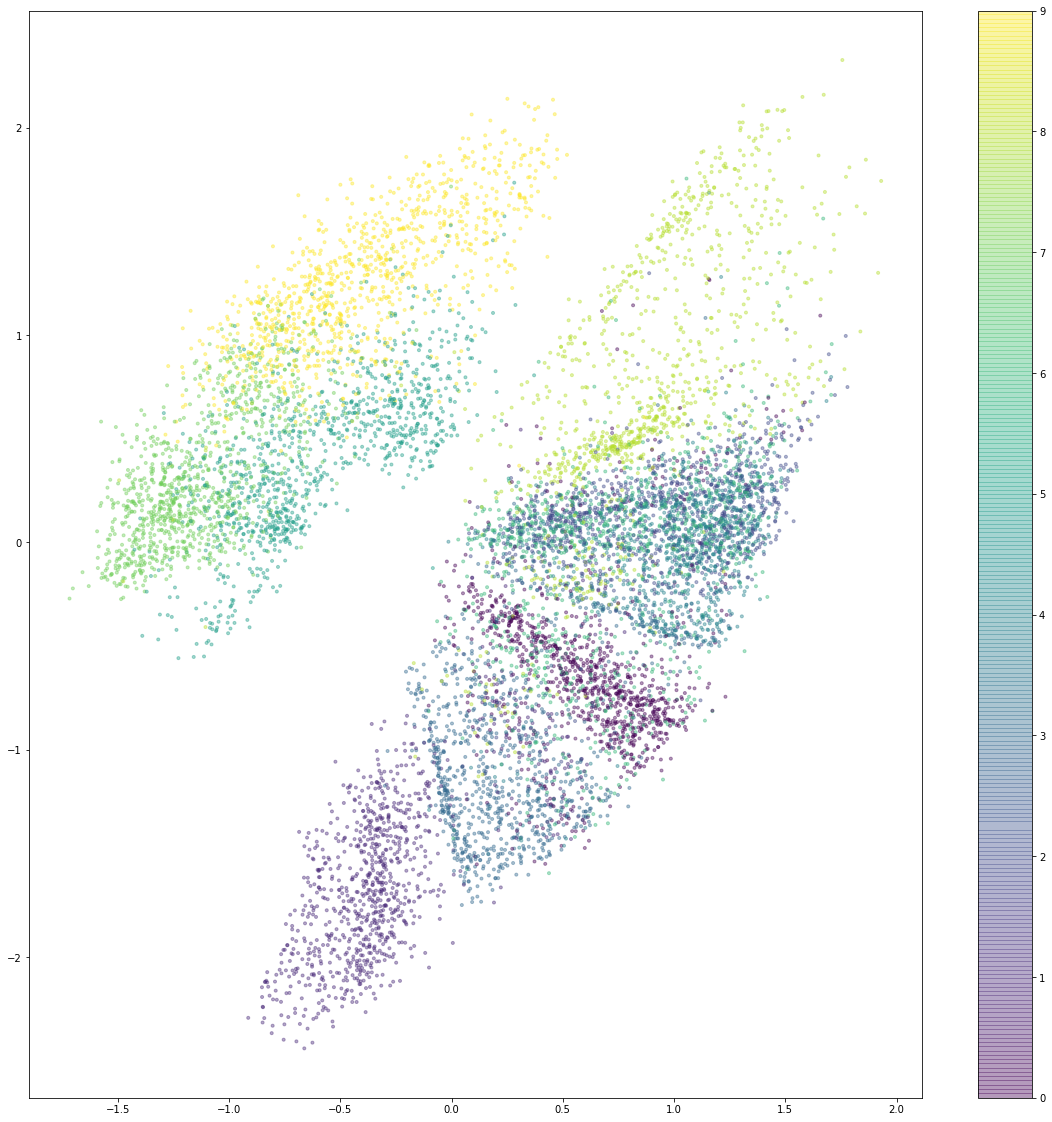

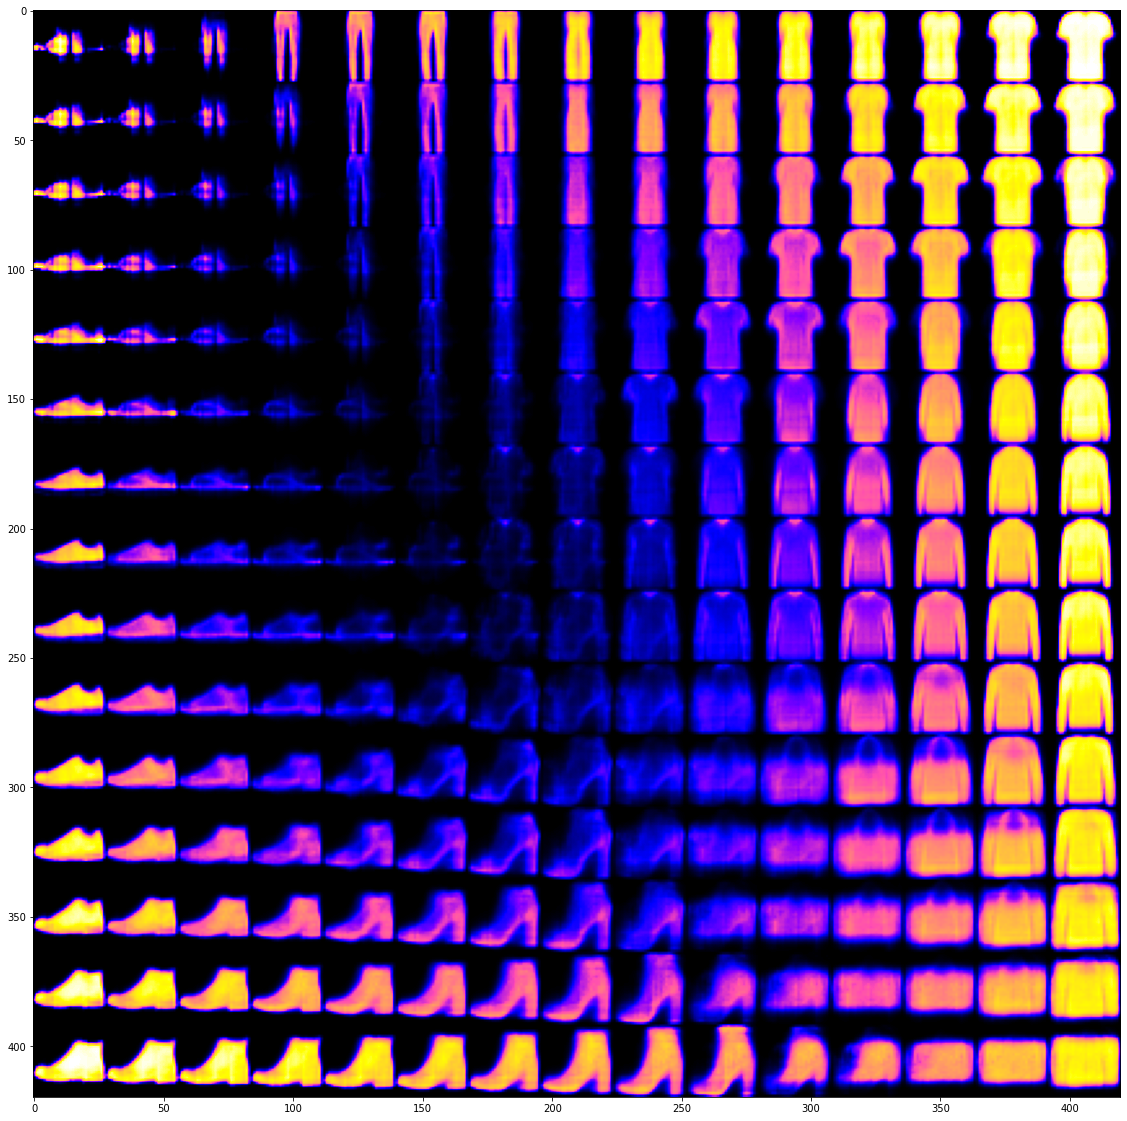

In [54]:
### Fashion Mnist Autoencoder ###
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import fashion_mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0


def nll(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)
    
    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


decoder = Sequential([
    Dense(intermediate_dim, input_shape=(latent_dim,), activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

vae.fit([x_train, np.zeros((x_train.shape[0], latent_dim))],
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test, np.zeros((x_test.shape[0], latent_dim))], x_test))

encoder = Model(x, z_mu)

z_test = encoder.predict(x_test, batch_size=batch_size)

plt.figure(figsize=(20, 20))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.savefig('scatter.png')


n = 15 
digit_size = 28

u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(20, 20))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gnuplot2')
plt.savefig('mapped.png')